In [1]:
import sys
from pathlib import Path
import pandas as pd # (Vamos precisar para carregar os dados)

# --- 1. Adicionar 'scripts' ao Path ---

# Path.cwd() é o diretório atual (no caso, a pasta 'notebooks')
# .parent nos leva para a raiz do projeto (pokemon-dashboard-project)
project_root = Path.cwd().parent

# Criamos o caminho para a pasta 'scripts'
scripts_path = project_root / "scripts"

# Adicionamos esse caminho ao sys.path (lista de locais onde o Python procura módulos)
if str(scripts_path) not in sys.path:
    sys.path.insert(0, str(scripts_path))
    print(f"Adicionado ao sys.path: {scripts_path}")

Adicionado ao sys.path: c:\Users\vinic\Downloads\teste-kayzen\pokemon-dashboard-project\scripts


In [2]:
from AutoClusterHPO import AutoClusterHPO
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy import stats
import numpy as np
from sklearn.preprocessing import StandardScaler

c:\Users\vinic\Downloads\teste-kayzen\pokemon-dashboard-project\av_pokemon\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Leitura e Tratamento de Dados

In [3]:
# Dicionário de dtypes para o pandas
pokemon_dtypes = {
    'id': 'int64',
    'name': 'string',  # Usar 'string' (dtype do pandas) é geralmente melhor que 'object'
    'hp': 'int64',
    'attack': 'int64',
    'defense': 'int64',
    'sp_attack': 'int64',
    'sp_defense': 'int64',
    'speed': 'int64',
    'generation': 'int64', # Ou 'category' se houver poucas gerações
    'legendary': 'boolean', # Usar 'boolean' (dtype do pandas) que aceita Nulos (NA)
    'types': 'object',      # 'object' é necessário se a coluna contiver listas
}

df_atributos = pd.read_json(r'..\\data\\raw\\pokemons_atributos.json', dtype=pokemon_dtypes)

df_atributos['generation'] = df_atributos['generation'].replace({'Gen2': 2, 'Gen3': 3, 'Gen4': 4, 'Gen5': 5, 'Gen6': 6, 'Gen7': 7, 'Gen8': 8}).astype('int64')

In [4]:
df_combats = pd.read_json(r'..\\data\\raw\\combats.json')

In [5]:
df_combats_winners = df_combats['winner'].value_counts().reset_index().rename(columns={'index': 'pokemon_id', 'winner': 'id', 'count':'wins'}).sort_values(by='id', ascending=False)

df_atributos = pd.merge(
df_atributos,
df_combats_winners,
on='id',  # Coluna com mesmo nome em ambos
how='left'
)

df_atributos['wins'] = df_atributos['wins'].fillna(0).astype('int64')

df_atributos.head()

,id,name,hp,attack,defense,sp_attack,sp_defense,speed,generation,legendary,types,wins
0,1,Bulbasaur,45,49,49,65,65,45,1,false,Grass/Poison,9
1,2,Ivysaur,60,62,63,80,80,60,1,false,Grass/Poison,17
2,3,Venusaur,80,82,83,100,100,80,1,false,Grass/Poison,15
3,4,Mega Venusaur,80,100,123,122,120,80,1,false,Grass/Poison,16
4,5,Charmander,39,52,43,60,50,65,1,false,Fire,9


# Análise Descritiva

In [6]:
df_atributos[['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'generation', 'wins']].describe()

,hp,attack,defense,sp_attack,sp_defense,speed,generation,wins
count,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000
mean,69.264080,78.968711,73.859825,72.836045,71.904881,68.244055,3.326658,12.495620
std,25.550218,32.464637,31.199180,32.739641,27.846265,29.063266,1.660292,7.413472
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.000000,0.000000
25%,50.000000,55.000000,50.000000,49.500000,50.000000,45.000000,2.000000,7.000000
50%,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.000000,12.000000
75%,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.000000,18.000000
max,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.000000,36.000000


In [7]:
df_atributos.isnull().sum()

id            0
name          0
hp            0
attack        0
defense       0
sp_attack     0
sp_defense    0
speed         0
generation    0
legendary     0
types         0
wins          0
dtype: int64

In [8]:
df_atributos['types'].nunique()

160

In [9]:
df_atributos['types'].value_counts().reset_index().head(20)

,types,count
0,Normal,60
1,Water,58
2,Psychic,38
3,Grass,33
4,Fire,28
5,Electric,27
6,Normal/Flying,24
7,Fighting,18
8,Bug,17
9,Fairy,15


In [10]:
df_atributos['legendary'].value_counts()

legendary
false    731
true      65
No         3
Name: count, dtype: int64

In [11]:
df_atributos['generation'].value_counts()

generation
1    165
5    165
3    160
4    121
2    106
6     82
Name: count, dtype: int64

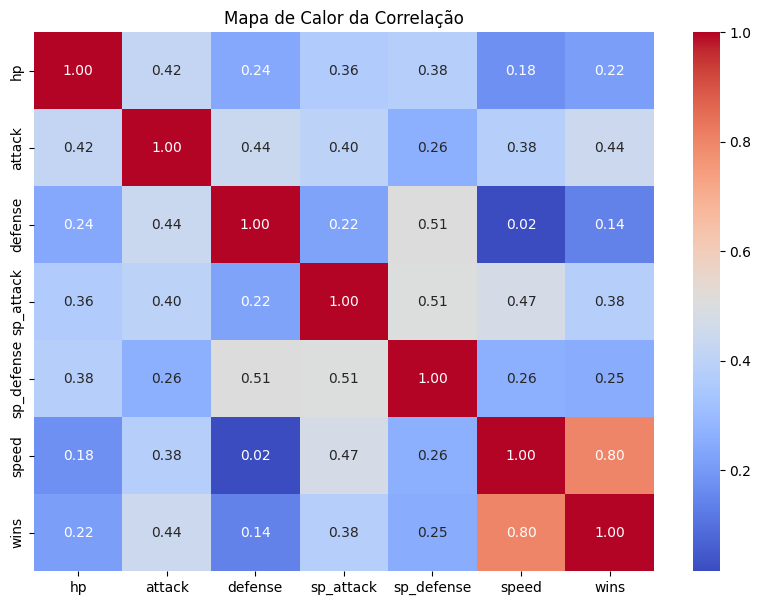

In [12]:
# Lista de colunas *apenas* numéricas
colunas_numericas = [
    'hp', 
    'attack', 
    'defense', 
    'sp_attack', 
    'sp_defense', 
    'speed', 
    'wins'
]

# Calcule a correlação apenas com elas
corr_matrix = df_atributos[colunas_numericas].corr()

# Agora você pode plotar o heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Mapa de Calor da Correlação")
plt.show()

# Clusterização

In [13]:
# Inicializar e aplicar o AutoCluster
autocluster_tool = AutoClusterHPO(max_evals_per_algo=20) 
clusters = autocluster_tool.fit_predict(df_atributos[['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'generation', 'wins']])
df_atributos['Clusters'] = clusters[0]

Iniciando otimização de hiperparâmetros...
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [00:00<00:00, 37.99trial/s, best loss: -0.5126778230541406]

Processo de AutoCluster concluído.
Melhor algoritmo: AgglomerativeClustering
Melhores parâmetros: {'linkage': 'single', 'n_clusters': 3}
Melhor pontuação CVI combinada: 0.5127


In [14]:
df_atributos['Clusters'].value_counts()

Clusters
0    796
2      2
1      1
Name: count, dtype: int64

In [15]:
df_atributos[(df_atributos['Clusters'] == 1) | (df_atributos['Clusters'] == 2)]

,id,name,hp,attack,defense,sp_attack,sp_defense,speed,generation,legendary,types,wins,Clusters
120,122,Chansey,250,5,5,35,105,50,1,false,Normal,3,2
229,231,Shuckle,20,10,230,10,230,5,2,false,Bug/Rock,0,1
260,262,Blissey,255,10,10,75,135,55,2,false,Normal,8,2


In [16]:
df_atributos.groupby('Clusters')[['attack', 'sp_attack', 'speed']].describe().T

Clusters                  0     1          2
attack    count  796.000000   1.0   2.000000
          mean    79.234925  10.0   7.500000
          std     32.233680   NaN   3.535534
          min      5.000000  10.0   5.000000
          25%     55.000000  10.0   6.250000
          50%     75.000000  10.0   7.500000
          75%    100.000000  10.0   8.750000
          max    190.000000  10.0  10.000000
sp_attack count  796.000000   1.0   2.000000
          mean    72.959799  10.0  55.000000
          std     32.697714   NaN  28.284271
          min     10.000000  10.0  35.000000
          25%     50.000000  10.0  45.000000
          50%     65.000000  10.0  55.000000
          75%     95.000000  10.0  65.000000
          max    194.000000  10.0  75.000000
speed     count  796.000000   1.0   2.000000
          mean    68.363065   5.0  52.500000
          std     29.020272   NaN   3.535534
          min      5.000000   5.0  50.000000
          25%     45.000000   5.0  51.250000
          50%     65.000000   5.0  52.500000
          75%     90.000000   5.0  53.750000
          max    180.000000   5.0  55.000000

In [17]:
df_atributos.groupby('Clusters')[['defense', 'sp_defense', 'speed', 'hp']].describe().T

Clusters                   0      1           2
defense    count  796.000000    1.0    2.000000
           mean    73.830402  230.0    7.500000
           std     30.582687    NaN    3.535534
           min      5.000000  230.0    5.000000
           25%     50.000000  230.0    6.250000
           50%     70.000000  230.0    7.500000
           75%     90.000000  230.0    8.750000
           max    230.000000  230.0   10.000000
sp_defense count  796.000000    1.0    2.000000
           mean    71.585427  230.0  120.000000
           std     27.210551    NaN   21.213203
           min     20.000000  230.0  105.000000
           25%     50.000000  230.0  112.500000
           50%     70.000000  230.0  120.000000
           75%     90.000000  230.0  127.500000
           max    200.000000  230.0  135.000000
speed      count  796.000000    1.0    2.000000
           mean    68.363065    5.0   52.500000
           std     29.020272    NaN    3.535534
           min      5.000000    5.0   50.000000
           25%     45.000000    5.0   51.250000
           50%     65.000000    5.0   52.500000
           75%     90.000000    5.0   53.750000
           max    180.000000    5.0   55.000000
hp         count  796.000000    1.0    2.000000
           mean    68.865578   20.0  252.500000
           std     23.824004    NaN    3.535534
           min      1.000000   20.0  250.000000
           25%     50.000000   20.0  251.250000
           50%     65.000000   20.0  252.500000
           75%     80.000000   20.0  253.750000
           max    190.000000   20.0  255.000000

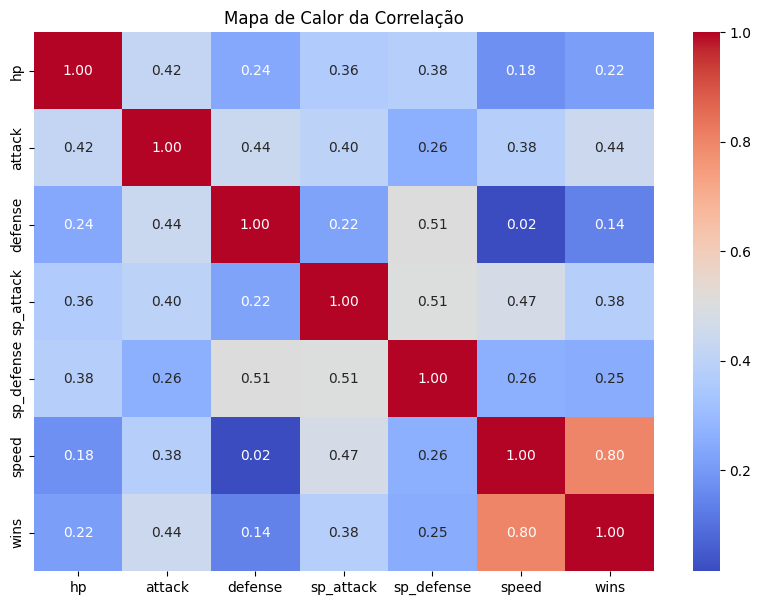

In [18]:
# Lista de colunas *apenas* numéricas
colunas_numericas = [
    'hp', 
    'attack', 
    'defense', 
    'sp_attack', 
    'sp_defense', 
    'speed', 
    'wins'
]

# Calcule a correlação apenas com elas
corr_matrix = df_atributos[colunas_numericas].corr()

# Agora você pode plotar o heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Mapa de Calor da Correlação")
plt.show()

# Modelagem Preditiva

In [20]:
# Inicializa o scaler
scaler = StandardScaler()

X = scaler.fit_transform(df_atributos[['speed']])
y = df_atributos['wins']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Criar uma instância do modelo de Regressão Linear
modelo = LinearRegression()

# 5. Treinar o modelo com os dados de treino
modelo.fit(X_train, y_train)

# 6. Fazer previsões nos dados de teste
y_pred = modelo.predict(X_test)

# 7. Avaliar a performance do modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 8. Exibir os resultados
print("--- Resultados da Avaliação ---")
print(f"Erro Quadrático Médio (MSE): {mse:.2f}")
print(f"Coeficiente de Determinação (R²): {r2:.2f}")
print("-" * 30)

# 7. CALCULAR RESÍDUOS E PREVISÕES DO CONJUNTO DE TREINO (ESSENCIAL PARA OS TESTES)
print("\nCalculando resíduos do conjunto de treino para verificação das suposições...")
valores_previstos_treino = modelo.predict(X_train)
residuos_treino = y_train - valores_previstos_treino

--- Resultados da Avaliação ---
Erro Quadrático Médio (MSE): 20.89
Coeficiente de Determinação (R²): 0.63
------------------------------

Calculando resíduos do conjunto de treino para verificação das suposições...


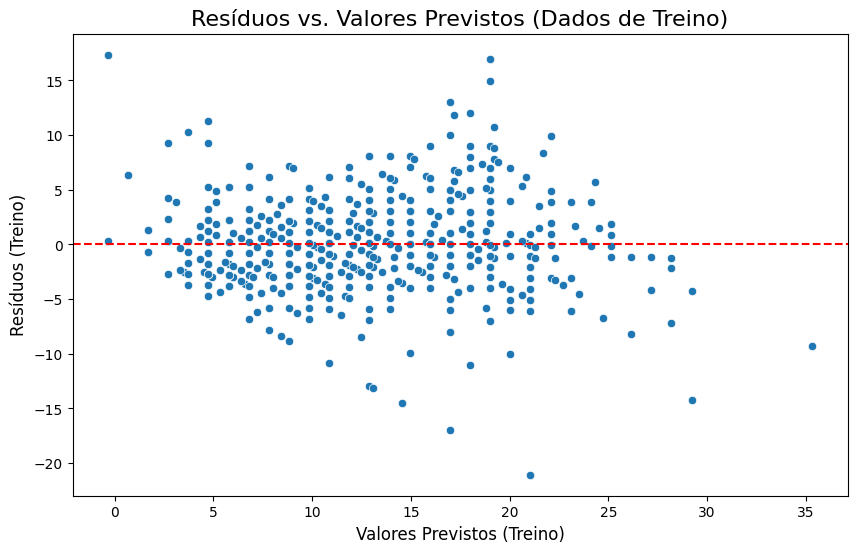

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=valores_previstos_treino.squeeze(), y=residuos_treino.squeeze())
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Resíduos vs. Valores Previstos (Dados de Treino)', fontsize=16)
plt.xlabel('Valores Previstos (Treino)', fontsize=12)
plt.ylabel('Resíduos (Treino)', fontsize=12)
plt.show()

Normalidade dos Residuos

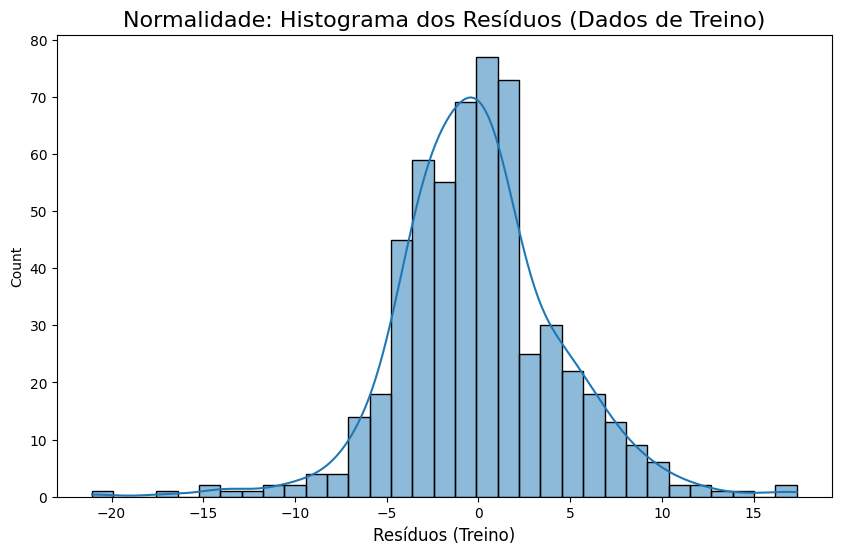

In [23]:
# Histograma
plt.figure(figsize=(10, 6))
sns.histplot(residuos_treino, kde=True)
plt.title('Normalidade: Histograma dos Resíduos (Dados de Treino)', fontsize=16)
plt.xlabel('Resíduos (Treino)', fontsize=12)
plt.show()

In [24]:
shapiro_test = stats.shapiro(residuos_treino)
print(f'Teste de Shapiro-Wilk (treino): Estatística={shapiro_test.statistic:.4f}, p-valor={shapiro_test.pvalue:.4f}')
if shapiro_test.pvalue < 0.05:
    print("Resultado: Os resíduos não parecem ser normalmente distribuídos (p < 0.05).")
else:
    print("Resultado: Os resíduos parecem ser normalmente distribuídos (p >= 0.05).")

Teste de Shapiro-Wilk (treino): Estatística=0.9686, p-valor=0.0000
Resultado: Os resíduos não parecem ser normalmente distribuídos (p < 0.05).


Independencia dos Residuos

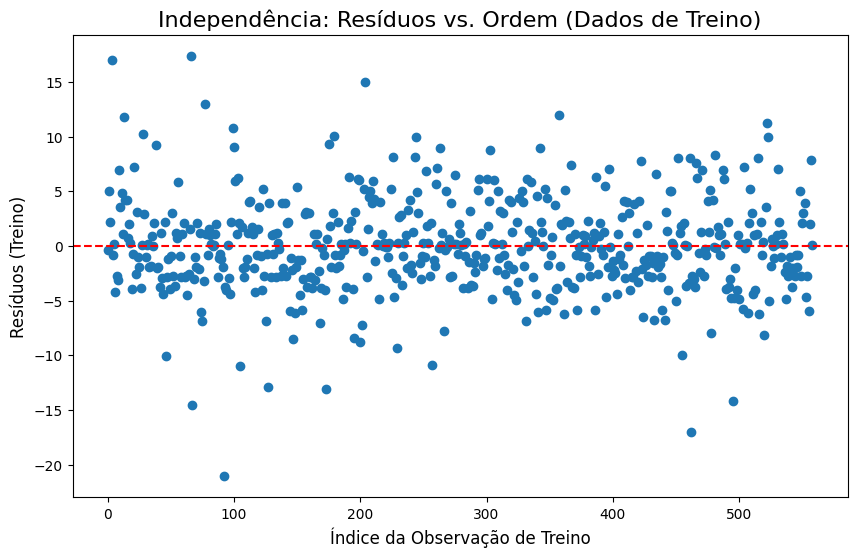

In [25]:
plt.figure(figsize=(10, 6))
# Usamos .reset_index() para garantir que o eixo x seja sequencial
residuos_df = pd.Series(residuos_treino.squeeze()).reset_index(drop=True)
plt.plot(residuos_df.index, residuos_df.values, marker='o', linestyle='')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Independência: Resíduos vs. Ordem (Dados de Treino)', fontsize=16)
plt.xlabel('Índice da Observação de Treino', fontsize=12)
plt.ylabel('Resíduos (Treino)', fontsize=12)
plt.show()

In [26]:
def durbin_watson_test(residuos):
    residuos_diff = np.diff(residuos, n=1)
    numerador = np.sum(residuos_diff**2)
    denominador = np.sum(residuos**2)
    return numerador / denominador

dw_stat = durbin_watson_test(residuos_treino.squeeze())
print(f'Estatística de Durbin-Watson (manual, treino): {dw_stat:.4f}')

Estatística de Durbin-Watson (manual, treino): 1.9067


Homocedasticidade

In [27]:
def breusch_pagan_test(residuos, X):
    n = len(residuos)
    k = X.shape[1]
    residuos_sq = residuos**2
    modelo_aux = LinearRegression()
    modelo_aux.fit(X, residuos_sq)
    r2_aux = modelo_aux.score(X, residuos_sq)
    lm_stat = n * r2_aux
    p_value = 1 - stats.chi2.cdf(lm_stat, df=k)
    return lm_stat, p_value

bp_stat, bp_p_value = breusch_pagan_test(residuos_treino.squeeze(), X_train)
print("Teste de Breusch-Pagan (Manual, treino):")
print(f"Estatística LM: {bp_stat:.4f}")
print(f"Valor-p: {bp_p_value:.4f}")
if bp_p_value < 0.05:
    print("Resultado: Há evidência de heterocedasticidade (p < 0.05).")
else:
    print("Resultado: Não há evidência de heterocedasticidade (p >= 0.05).")

Teste de Breusch-Pagan (Manual, treino):
Estatística LM: 14.5380
Valor-p: 0.0001
Resultado: Há evidência de heterocedasticidade (p < 0.05).
